# Basic python imports and model settings

In [1]:
import underworld.visualisation as vis

from underworld import function as fn
import underworld as uw

import matplotlib.pyplot as pyplot
import numpy as np
from scipy.spatial import distance

import math
import os
import sys

import time

from scipy.signal import savgol_filter

# details of the bottom curve
# details of the bottom curve
L = [160, 80, 40, 20, 10, 5]
i = 5

maxX = L[i] * 1000.
min_bed_height = 500.           # we want a minimum of 500 m of rock beneath the ice
omega = 2.0 * np.pi / maxX
amplitude = 500.
average_bedthickness = 1000.
surface_height = average_bedthickness + amplitude + min_bed_height
maxY = surface_height

minY = minX = 0.

g = 9.81
ice_density = 910.

A = 1e-16
n = 3.

resX = 100
resY = 30

resX = 128
resY = 64

print("resX: " + str(resX) + " resY: " + str(resY))

# generate output path
outputPath = os.path.join(os.path.abspath("."), "output_" + str(maxX) + "/")
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

os.chdir(outputPath)
    
delta_timestep = 1.						# in years, used in the main loop
# after how many timesteps do we need new figures?
update_figures_after_n_timesteps = 1
number_of_deformation_lines = 11

number_of_deformation_points = 50000
distance_between_deformation_lines = maxY / (number_of_deformation_lines + 1)

cell_height = maxY / (resY + 1)
cell_width = maxX / (resX + 1)

resX: 128 resY: 64


# Mesh + mesh variables

In [2]:
elementType = "Q1/dQ0"
#elementType = "Q2/dQ1"
#elementType = "Q1/dPc1"
#elementType = "Q2/dPc1"

mesh = uw.mesh.FeMesh_Cartesian(elementType=(elementType),
                                elementRes=(resX, resY),
                                minCoord=(minX, minY),
                                maxCoord=(maxX, maxY),
                                periodic=[True, False])

submesh = mesh.subMesh

# save the mesh
# mesh.save(outputPath + "mesh.h5")

velocityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=mesh.dim)
#pressureField = uw.mesh.MeshVariable(mesh=mesh.subMesh, nodeDofCount=1)
pressureField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

viscosityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

strainRateField = mesh.add_variable(nodeDofCount=1)

#pressureField.data[:] = 0.
velocityField.data[:] = [0., 0.]

# Initialise the 'materialVariable' data to represent different materials.
materialA = 0  	# accommodation layer, a.k.a. Sticky Air
materialV = 1  	# ice, isotropic
materialR = 2   # rock
materialT = 5   # test material in order to test eg interface detection

coord = fn.input()

z_bed_function = surface_height - average_bedthickness + amplitude * fn.math.sin(omega * coord[0])

# Define the ice-rock / ice-air interface 

In [3]:
botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets['Top_VertexSet']

iceRockInterfaceSet = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)
iceRockInterfaceSet.data[:] = False

ySpacing = maxY / (resY - 1.)

for i, m in np.ndenumerate(mesh.data[:,1]):
    
    val = 2.5*ySpacing + surface_height - average_bedthickness + amplitude * np.sin(omega * mesh.data[i,0])
    
    if m < val:
        if abs(m - val) < 0.98*ySpacing:
            iceRockInterfaceSet.data[i] = True

l = np.where(iceRockInterfaceSet.data[:])[0]
inds = mesh.data[l,0].argsort()
iceRockInterfaceSet = l[inds]

#iceRockInterfaceSet = np.delete(iceRockInterfaceSet, iceRockInterfaceSet.size - 1)
#iceRockInterfaceSet = np.delete(iceRockInterfaceSet, iceRockInterfaceSet.size - 1)

#print (mesh.data[iceRockInterfaceSet])
print (iceRockInterfaceSet.size)

#### 

iceAirInterfaceSet = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)
iceAirInterfaceSet.data[:] = False
iceAirInterfaceSet.data[topSet] = True

l = np.where(iceAirInterfaceSet.data[:])[0]
inds = mesh.data[l,0].argsort()
iceAirInterfaceSet = l[inds]
print (iceAirInterfaceSet.size)

127
129


In [10]:
botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets['Top_VertexSet']

dx = (maxX - minX) / resX
iceRockInterface = []
iceAirInterface = []

dx = (maxX - minX) / resX

for index in range(resX+1):
    
    start_x = dx * index

    interface_y =  surface_height - average_bedthickness + amplitude * np.sin(start_x * (np.pi * 2.) / (maxX-minX) )
                
    #ind = np.where(abs(mesh.data[:,0] - start_x) < 0.01*dx)
    iceRockInterface.append([start_x, interface_y])
    iceAirInterface.append([start_x, maxY])


# Deform the mesh to increase resolution at the interface

In [ ]:
def mesh_deform(section,fixPoint,mi):
    
    # fixPoint: the position to be refined
    # mi: representing the gradient of mesh resolution; the larger mi, the larger gradient
    # generally, mi ranges from 0.1 to 3, dependnig on the resolution 
    
    for index in range(len(section)):
        
        maxCoord = np.max(section)
        minCoord = np.min(section)
        
        if  section[index] <= fixPoint:
            zz_sqrt = (fixPoint - section[index])**mi
            zz_sqrt_max = (fixPoint - minCoord)**mi
            section[index] = fixPoint - (fixPoint - section[index]) * zz_sqrt / zz_sqrt_max

        if  section[index] >= fixPoint:
            zz_sqrt = (section[index] - fixPoint)**mi
            zz_sqrt_max = (maxCoord - fixPoint)**mi
            section[index] = fixPoint + (section[index] - fixPoint) * zz_sqrt/zz_sqrt_max        
    
    return section

dx = (maxX - minX) / resX
#lx = []
#ly = []

with mesh.deform_mesh():

    for index in range(resX+1):  
        
        start_x = dx * index
        
        interface_y =  surface_height - average_bedthickness + amplitude * np.sin(start_x * (np.pi * 2.) / (maxX-minX) )
        
        #print (start_x,interface_y)
        #lx.append(start_x)
        #ly.append(interface_y)
        
        #ind = np.where(abs(mesh.data[:,0] - start_x) < 0.01*dx)
        ind = np.where(abs(mesh.data[:,0] - start_x) < 0.01*dx)

        mesh.data[ind[0],1] = mesh_deform(mesh.data[ind[0],1], interface_y, 2.0)


In [ ]:
# visualising the result
figMesh = vis.Figure(figsize=(1200,600))
figMesh.append( vis.objects.Mesh(mesh) )
figMesh.show()

# Swarm

In [5]:
part_per_cell = 50
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(
    swarm=swarm, particlesPerCell=part_per_cell)
swarm.populate_using_layout(layout=swarmLayout)

measurementSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

# create pop control object
pop_control1 = uw.swarm.PopulationControl(swarm, aggressive=True, particlesPerCell=part_per_cell)
pop_control2 = uw.swarm.PopulationControl(measurementSwarm)

# ### Create a particle advection system
#
# Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).
advector1 = uw.systems.SwarmAdvector(swarm=swarm,velocityField=velocityField, order=2)
advector2 = uw.systems.SwarmAdvector(swarm=measurementSwarm,     velocityField=velocityField, order=2)

# Tracking different materials

materialVariable = swarm.add_variable(dataType="int", count=1)

numbMeasurementPoints = resX + 1
xloc = np.linspace(0, maxX, numbMeasurementPoints).reshape(-1,1)
yloc = (surface_height - average_bedthickness + amplitude * np.sin(omega * xloc)).reshape(-1,1)
xycoor = np.concatenate((xloc,yloc),axis = 1)

measurementSwarm.add_particles_with_coordinates(xycoor)

particleDensity = swarm.add_variable(dataType="double", count=1)
particleDensity.data[:] = 0.0

coord = fn.input()

conditions = [(coord[1] > surface_height, materialA),
              (coord[1] < z_bed_function, materialR),
              (True, materialV)]

materialVariable.data[:] = fn.branching.conditional(conditions).evaluate(swarm)

#pyplot.plot(measurementSwarm.data[:,0], measurementSwarm.data[:,1], color='black')

# Functions

In [6]:
strainRateTensor = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateTensor)

minViscosityIceFn = fn.misc.constant(1e+10 / 3.1536e7)
maxViscosityIceFn = fn.misc.constant(1e+15 / 3.1536e7)

viscosityFnAir = fn.misc.constant(1e6 / 3.1536e7)
viscosityFnRock = fn.misc.constant(1e22 / 3.1536e7)

viscosityFnIceBase = 0.5 * A ** (-1./n) * (strainRate_2ndInvariantFn**((1.-n) / float(n)))
viscosityFnIce = fn.misc.max(fn.misc.min(viscosityFnIceBase, maxViscosityIceFn), minViscosityIceFn)

viscosityMap = {
                materialV: viscosityFnIce,
                materialA: viscosityFnAir,
                materialR: viscosityFnRock,
               }

viscosityFn = fn.branching.map( fn_key=materialVariable, mapping=viscosityMap )

logViscosityFn = fn.math.log10( fn.misc.max( fn.misc.min( viscosityFnIceBase, viscosityFnRock ), viscosityFnAir ) )

devStressFn = 2.0 * viscosityFn * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn * 2.0

densityFnAir = fn.misc.constant( 0. )
densityFnIce = fn.misc.constant( ice_density )
densityFnRock = fn.misc.constant( 2700. )

densityMap = {
                materialA: densityFnAir,
                materialV: densityFnIce,
                materialR: densityFnRock
             }

densityFn = fn.branching.map(fn_key=materialVariable, mapping=densityMap)

particleDensity.data[:] = densityFn.evaluate(swarm)

surf_inclination = 0.5 * np.pi / 180. # 0.1 = Experiment D, 0.5 = Experiment B
#surf_inclination = 0.
z_hat = (math.sin(surf_inclination), - math.cos(surf_inclination))
#z_hat = (0.00872653549, -0.99996192306417128874)

buoyancyFn = densityFn * z_hat * 9.81

# Solver and boundary conditions

In [7]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
base = mesh.specialSets["MinJ_VertexSet"]
top = mesh.specialSets["MaxJ_VertexSet"]

velocityField.data[:] = [0., 0.]

leftSet = mesh.specialSets['Left_VertexSet']
rightSet = mesh.specialSets['Right_VertexSet']

### Dirichlet
condition1 = uw.conditions.DirichletCondition(variable=velocityField,indexSetsPerDof=(botSet, botSet))

velocityField.data[:] = [0., 0.]

stokes = uw.systems.Stokes(
    velocityField=velocityField,
    pressureField=pressureField,
    voronoi_swarm=swarm,
    conditions=[
            condition1,
            ],
    fn_viscosity=viscosityFn,
    fn_bodyforce=buoyancyFn,
)

solver = uw.systems.Solver(stokes)

#solver.set_inner_method("lu")
#solver.set_inner_method("superlu")
# solver.set_inner_method("mumps")
# solver.set_inner_method("superludist")
solver.set_inner_method("mg")
#solver.set_inner_method("nomg")

# solver.set_penalty(1.0e10)  # higher penalty = larger stability
# solver.options.scr.ksp_rtol = 1.0e-3

# nl_tol = 2.e1
nl_tol = 5.e-3

surfaceArea = uw.utils.Integral( fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral( fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

def calibrate_pressure():

    global pressureField
    global surfaceArea
    global surfacePressureIntegral

    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area

    print (f'Calibration pressure {p0 / area}')

# test it out
try:
    # solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
    solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
    # solver.solve(nonLinearIterate=True)

    # print stats to a file
    original_stdout = sys.stdout # Save a reference to the original standard output
    with open('stats_time_' + str(resX) + 'x' + str(resY) + '.txt', 'w') as f:
        sys.stdout = f # Change the standard output to the file we created.
        solver.print_stats()
        sys.stdout = original_stdout # Reset the standard output to its original value
        
    solver.print_stats()
except:
    print("Solver died early..")
    exit(0)

Calibration pressure 5296.833100335925
Calibration pressure -355.6960925005397
Calibration pressure -2501.2838599938314
Calibration pressure -3750.5029027349988
Calibration pressure -4109.456294177712
Calibration pressure -4208.66318138282
Calibration pressure -4464.629805080532
Calibration pressure -4640.861351517876
Calibration pressure -4643.1926930135405
Calibration pressure -4759.697133052042
Calibration pressure -4737.627108102189
Calibration pressure -4785.644756761057
Calibration pressure -4864.87580338625
Calibration pressure -4816.812878892955

 
Pressure iterations:  47
Velocity iterations:  18 (presolve)      
Velocity iterations: 467 (pressure solve)
Velocity iterations:  15 (backsolve)     
Velocity iterations: 500 (total solve)   
 
SCR RHS  setup time: 1.8531e-02
SCR RHS  solve time: 9.6501e-02
Pressure setup time: 1.9226e-03
Pressure solve time: 1.6186e+00
Velocity setup time: 4.7684e-07 (backsolve)
Velocity solve time: 4.7332e-02 (backsolve)
Total solve time   : 1.794

# Output

topo


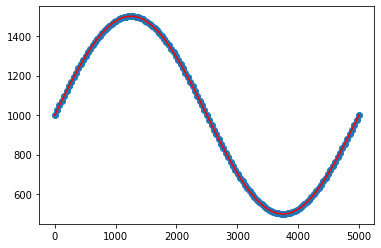

top x vel


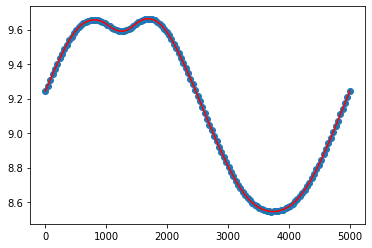

top y vel


top total vel


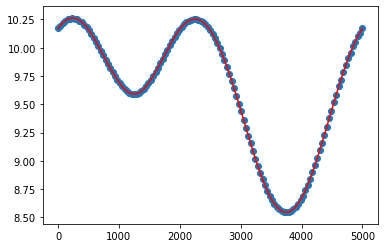

tau integr.


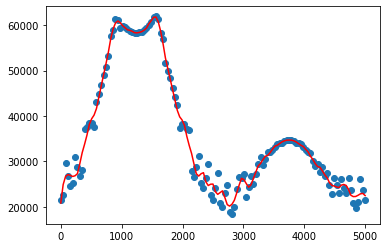

tau dir.


basal pressure integr.


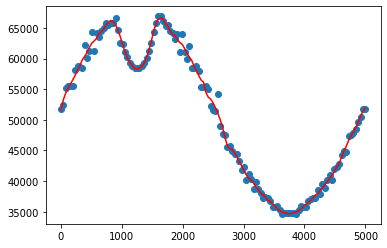

basal pressure dir.


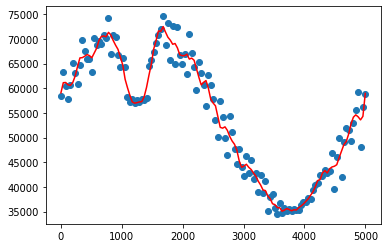

In [12]:
## correct the pressure
meshCorrectedPressure = mesh.add_variable( 1 )
meshSecondCorrectedPressure = mesh.add_variable( 1 )

## a) from the pressureField
meshCorrectedPress = uw.utils.MeshVariable_Projection( meshCorrectedPressure, pressureField, type=1 )
meshCorrectedPress.solve()

## b) from the stranirate tensor
pressureFn = (strainRateTensor[0] + strainRateTensor[1]) * viscosityFn
meshSecondCorrectedPress = uw.utils.MeshVariable_Projection( meshSecondCorrectedPressure, pressureFn, type=1 )
meshSecondCorrectedPress.solve()

## shear stress as saved to disk
shearStressFn = 2.0 * viscosityFn * strainRateTensor[2]
meshShearStress = mesh.add_variable( 1 )

projectorStress = uw.utils.MeshVariable_Projection( meshShearStress, shearStressFn, type=0 )
projectorStress.solve()

## second invariant of stress as saved to disk
secInvStressFn = 2.0 * viscosityFn * strainRate_2ndInvariantFn
secInvStress = mesh.add_variable( 1 )

projectorStress = uw.utils.MeshVariable_Projection( secInvStress, secInvStressFn, type=0 )
projectorStress.solve()

# save to disc
outputFile = os.path.join(os.path.abspath("."), outputPath + "output_" + str(maxX) + ".csv")

####

x = np.linspace(0, maxX, resX+1)
interfacex = [item[0] for item in iceRockInterface]
interfacey = [item[1] for item in iceRockInterface]

airinterfacey = [maxY for item in range(resX + 1)]

iceRockInterface = np.array(iceRockInterface)
iceAirInterface = np.array(iceAirInterface)

add = 2.5 * cell_height

###

shearstress_xy = []
corr_shearstress_xy = []
for i,j in zip(interfacex,interfacey):
    shearstress_xy.append(shearStressFn.evaluate((i,j + add))[0][0])
    corr_shearstress_xy.append(meshShearStress.evaluate((i,j + add))[0][0])

secinvstress = []
corr_secinvstress = []
for i,j in zip(interfacex,interfacey):
    secinvstress.append(secInvStressFn.evaluate((i,j + add))[0][0])
    corr_secinvstress.append(secInvStress.evaluate((i,j + add))[0][0])

####

pressure = []
corr_pressure = []
for i,j in zip(interfacex,interfacey):
    pressure.append(pressureField.evaluate((i, j + add))[0][0])
    corr_pressure.append(meshCorrectedPressure.evaluate((i, j + add))[0][0])
    #pressure.append(pressureFn.evaluate((i,j+10))[0][0])

with open(outputFile, "w") as text_file:

    text_file.write("X," + "Y," + "surf vx," + "surf vy," + "tauxy integr.," + "tauxy dir.," + "secinvare integr.," + "secinvar dir.," + "P integr.," + "P dir.," + "\n")
    
    for i, j in np.ndenumerate(iceAirInterfaceSet):
        i = i[0]
        textline = str(interfacex[i]) + "," + str(interfacey[i]) + "," + str(velocityField.data[j][0]) + "," + str(velocityField.data[j][1]) +   ","             + str(corr_shearstress_xy[i]) +   "," + str(shearstress_xy[i]) + "," + str(corr_secinvstress[i]) + "," + str(secinvstress[i]) + "," + str(corr_pressure[i]) + "," + str(pressure[i]) + "\n"
        
        text_file.write(textline)


# In[116]:


# plot saved files

outputFile = outputPath + "output_" + str(maxX) + ".csv"
a = np.loadtxt(open(outputFile, "rb"), delimiter=",", skiprows=1)
a = a.T

print ("topo")
pyplot.scatter (a[0], a[1])
yhat = savgol_filter(a[1], 13, 7)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("top x vel")
pyplot.scatter (a[0], a[2])
yhat = savgol_filter(a[2], 13, 7)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("top y vel")
pyplot.scatter (a[0], a[3])
yhat = savgol_filter(a[3], 13, 9)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("top total vel")
pyplot.scatter (a[0], np.sqrt(a[3]**2 + a[2]**2))
yhat = savgol_filter(np.sqrt(a[3]**2 + a[2]**2), 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("tau integr.")
pyplot.scatter (a[0], a[4])
yhat = savgol_filter(a[4], 13, 4)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("tau dir.")
pyplot.scatter (a[0], a[5])
yhat = savgol_filter(a[5], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("basal pressure integr.")
pyplot.scatter (a[0], a[6])
yhat = savgol_filter(a[6], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("basal pressure dir.")
pyplot.scatter (a[0], a[7])
yhat = savgol_filter(a[7], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

In [16]:
# plot figures

figinflow = vis.Figure(figsize=(1800,500), title="free slip with in/out flow")
figinflow.append(vis.objects.VectorArrows(mesh, velocityField))
figinflow.append(vis.objects.Surface(mesh, uw.function.math.dot(velocityField,velocityField), colours="gebco"))
figinflow.save_image(outputPath + "velocity_" + str(maxX) + ".png")

figMaterial = vis.Figure(figsize=(1800, 500), title="Material")
figMaterial.append(vis.objects.Points( swarm, materialVariable, pointSize=1.0))
figMaterial.save_image(outputPath + "material_" + str(maxX) + ".png")

figDensity = vis.Figure(figsize=(1800, 500), title="Density")
figDensity.append(vis.objects.Points( swarm, particleDensity, pointSize=1.0))
figDensity.save_image(outputPath + "density_" + str(maxX) + ".png")

figViscosity = vis.Figure(figsize=(1800, 500), title="viscosity")
figViscosity.append(vis.objects.Surface(mesh, logViscosityFn))
figViscosity.save_image(outputPath + "logviscosity_" + str(maxX) + ".png")

figPressure = vis.Figure(figsize=(1800, 500), title="pressure")
figPressure.append(vis.objects.Surface(mesh, pressureField))
figPressure.save_image(outputPath + "pressure_" + str(maxX) + ".png")

figShearStress = vis.Figure(figsize=(1800, 500), title="corr_shearstress_xy")
figShearStress.append(vis.objects.Surface(mesh, meshShearStress))
figShearStress.save_image(outputPath + "corr_shearstress_xy" + str(maxX) + ".png")

'/home/jovyan/workspace/Exp-B/output_5000.0/corr_shearstress_xy5000.0.png'

In [17]:
# finally save meshvars, swarmvars, xdmf vars
xdmf_info_mesh    = mesh.save('mesh.h5')
xdmf_info_meshVelocityField = velocityField.save('meshVelocityField.h5')
xdmf_info_meshShearStress = meshShearStress.save('meshShearStress.h5')
xdmf_info_meshCorrectedPressure = meshCorrectedPressure.save('meshCorrectedPressure.h5')

# swarm
xdmf_info_swarm    = swarm.save('swarm.h5')
xdmf_info_swarmMaterialVariable = materialVariable.save('swarmMaterialVariable.h5')

# xdmf mesh
velocityField.xdmf('meshVelocityField.xdmf', xdmf_info_meshVelocityField, "velocityField", xdmf_info_mesh, "TheMesh", modeltime=0.0)
meshShearStress.xdmf('meshShearStress.xdmf', xdmf_info_meshShearStress, "meshShearStress", xdmf_info_mesh, "TheMesh", modeltime=0.0)
meshCorrectedPressure.xdmf('meshCorrectedPressure.xdmf', xdmf_info_meshCorrectedPressure, "correctedPressureField", xdmf_info_mesh, "TheMesh", modeltime=0.0)

# xdmf swarm
materialVariable.xdmf('swarmMaterialVariable.xdmf', xdmf_info_swarmMaterialVariable, "material", xdmf_info_swarm, "TheSwarm", modeltime=0.0)